# Anotações

## Modelo ARIMA
#### O que é:
- AutoRegressive Integrated Moving Average (ARIMA)
- ARIMA(p,d,q)
- p = order of the autoregressive part; (encontra através do PACF)
- d = degree of first differencing involved;
- q = order of the moving average part. (encontra através do ACF)
- Podemos usar Auto ARIMA para achar os parâmetros automaticamente

#### Special Cases:
- White noise	ARIMA(0,0,0)
- Random walk	ARIMA(0,1,0) with no constant
- Random walk with drift	ARIMA(0,1,0) with a constant
- Autoregression	ARIMA(p,0,0)
- Moving average	ARIMA(0,0,q)

#### Passo a Passo com Auto ARIMA
- Dickey-Fuller: Verificar estacionaridade através do teste. Diferenciar até achar p-value < 0.05.
- Rodar Auto ARIMA
- P(Ljung-Box) (Summary Table): > 0.05 significa que residuos não tem autocorrelação.
- P(Jarque-Bera) (Summary Table): > 0.05 significa que residuos são normalmente distribuídos.
- P(Heteroskedasticity) (Summary Table): > 0.05 significa que a variância dos resíduos é constante.
- Skew (Summary Table): próximo de 0 significa simétrico
- Kurtosis (Summary Table): próximo de 3 é mesokurtic
- Aplicar transformações se necessário


## Modelo VAR
#### O que é:
- Vector Autoregression (VAR)
- Explica como uma time serie impacta a outra

#### Passo a Passo com VAR
- Dickey-Fuller: Verificar estacionaridade de todas as variáveis através do teste. Diferenciar até achar p-value < 0.05.
- Rodar VAR order selection e escolher o lag com menor valor, principalmente quanto ao BIC e AIC.
- Usar esse lag para rodar o modelo VAR.
- Granger Causality: < 0.05 indica causalidade Granger.


| Modelo                           | Característica Principal                                                 | Quando Usar                                                                 |
| -------------------------------- | ------------------------------------------------------------------------ | --------------------------------------------------------------------------- |
| **ARIMA**                        | Modela séries univariadas com componentes autorregressivos e média móvel | Previsão de uma única série temporal (como SELIC)                           |
| **ARIMAX**                       | ARIMA com variáveis exógenas                                             | Quando variáveis como IPCA influenciam a SELIC                              |
| **VAR**                          | Modela relações dinâmicas entre múltiplas séries                         | Análise conjunta de séries estacionárias (ex: SELIC, IPCA, dólar)           |
| **VECM**                         | VAR com correção de erros para séries cointegradas                       | Séries não estacionárias, mas cointegradas (têm tendência comum)            |
| **SVAR**                         | VAR com restrições estruturais                                           | Análise de choques econômicos com causalidade estrutural                    |
| **GARCH**                        | Modela variância condicional (volatilidade)                              | Quando há heterocedasticidade (volatilidade variável, ex: inflação)         |
| **Random Forest Regressor (ML)** | Ensemble de árvores de decisão                                           | Previsão de séries com várias variáveis explicativas, bom para comparação   |
| **XGBoost (ML)**                 | Gradient boosting otimizado                                              | Previsão potente com grande desempenho; útil para modelos explicativos      |
| **LSTM (Deep Learning)**         | Rede neural para dados sequenciais                                       | Captura padrões de longo prazo e não linearidades em séries temporais       |
| **Dynamic Factor Models (DFM)**  | Reduz séries para fatores ocultos                                        | Quando há muitas séries macroeconômicas; usado em nowcasting, análise geral. +10 variáveis e correlacionadas |


In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import acorr_ljungbox

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
selic = pd.read_csv("./selic.csv").reset_index(drop=True)

In [3]:
selic["Data"] = pd.to_datetime(selic["Data"], format='%d/%m/%Y')

selic = selic.set_index("Data")

selic_mensal = selic.resample("M").mean()

In [4]:
ipca = pd.read_csv("./ipca.csv", sep=";")

In [5]:
ipca = ipca[:-1]

In [6]:
ipca["Data"] = pd.to_datetime(ipca["Data"], format="%m/%Y")
ipca = ipca.set_index("Data")
ipca["ipca"] = ipca["ipca"].astype(str).str.replace(",",".")
ipca["ipca"] = ipca["ipca"].astype(float)

In [7]:
ipca = ipca.reset_index()
merged = pd.merge(selic, ipca, on = "Data", how="inner")
merged = merged.rename(columns={"ipca":"IPCA"})
merged = merged.rename(columns={"Data":"data"})
merged = merged.rename(columns={"Unnamed: 1":"Selic"})
merged = merged.set_index("data")
merged.index = pd.DatetimeIndex(merged.index).to_period('M').to_timestamp()


In [8]:
merged

,Selic,IPCA
data,,
2008-07-01,12.25,0.53
2008-08-01,13.00,0.28
2008-09-01,13.00,0.26
2008-10-01,13.75,0.45
2008-11-01,13.75,0.36
2008-12-01,13.75,0.28
2009-01-01,13.75,0.48
2009-02-01,12.75,0.55
2009-03-01,12.75,0.20


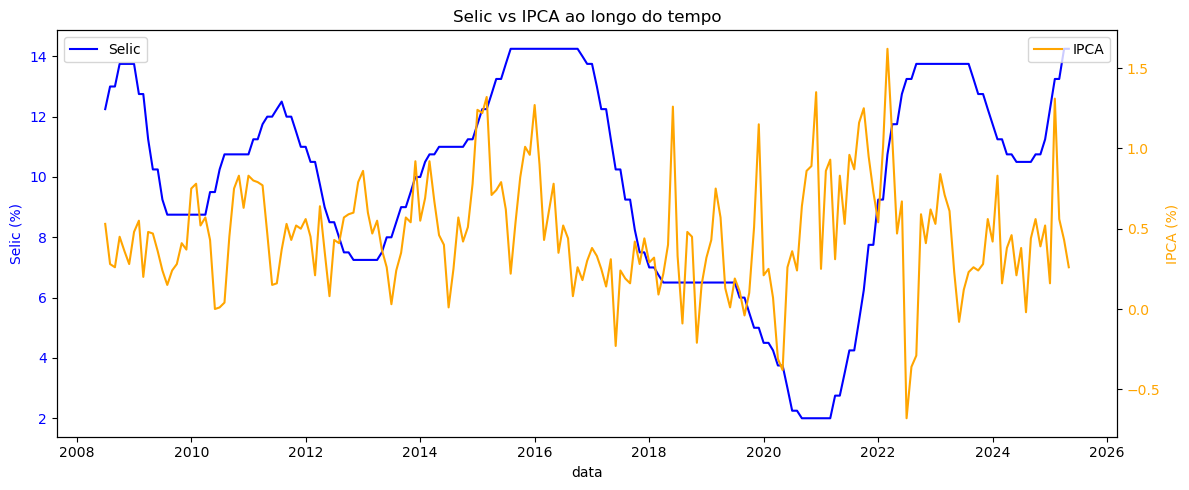

In [9]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Primeiro eixo Y: Selic
sns.lineplot(data=merged, x="data", y="Selic", ax=ax1, color="blue", label="Selic")
ax1.set_ylabel("Selic (%)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

# Segundo eixo Y: IPCA
ax2 = ax1.twinx()
sns.lineplot(data=merged, x="data", y="IPCA", ax=ax2, color="orange", label="IPCA")
ax2.set_ylabel("IPCA (%)", color="orange")
ax2.tick_params(axis='y', labelcolor='orange')

plt.xticks(rotation=45)
plt.title("Selic vs IPCA ao longo do tempo")
plt.tight_layout()
plt.show()


In [510]:
merged.corr(numeric_only=True)

,Selic,IPCA
Selic,1.00000,-0.00868
IPCA,-0.00868,1.00000


In [336]:
result_ipca = seasonal_decompose(merged["IPCA"], model = "additive", period = 12)
trend_ipca = result_ipca.trend
seasonal_ipca = result_ipca.seasonal
residual_ipca = result_ipca.resid

In [337]:
result_selic = seasonal_decompose(merged["Selic"], model = "additive", period = 12)
trend_selic = result_selic.trend
seasonal_selic = result_selic.seasonal
residual_selic = result_selic.resid

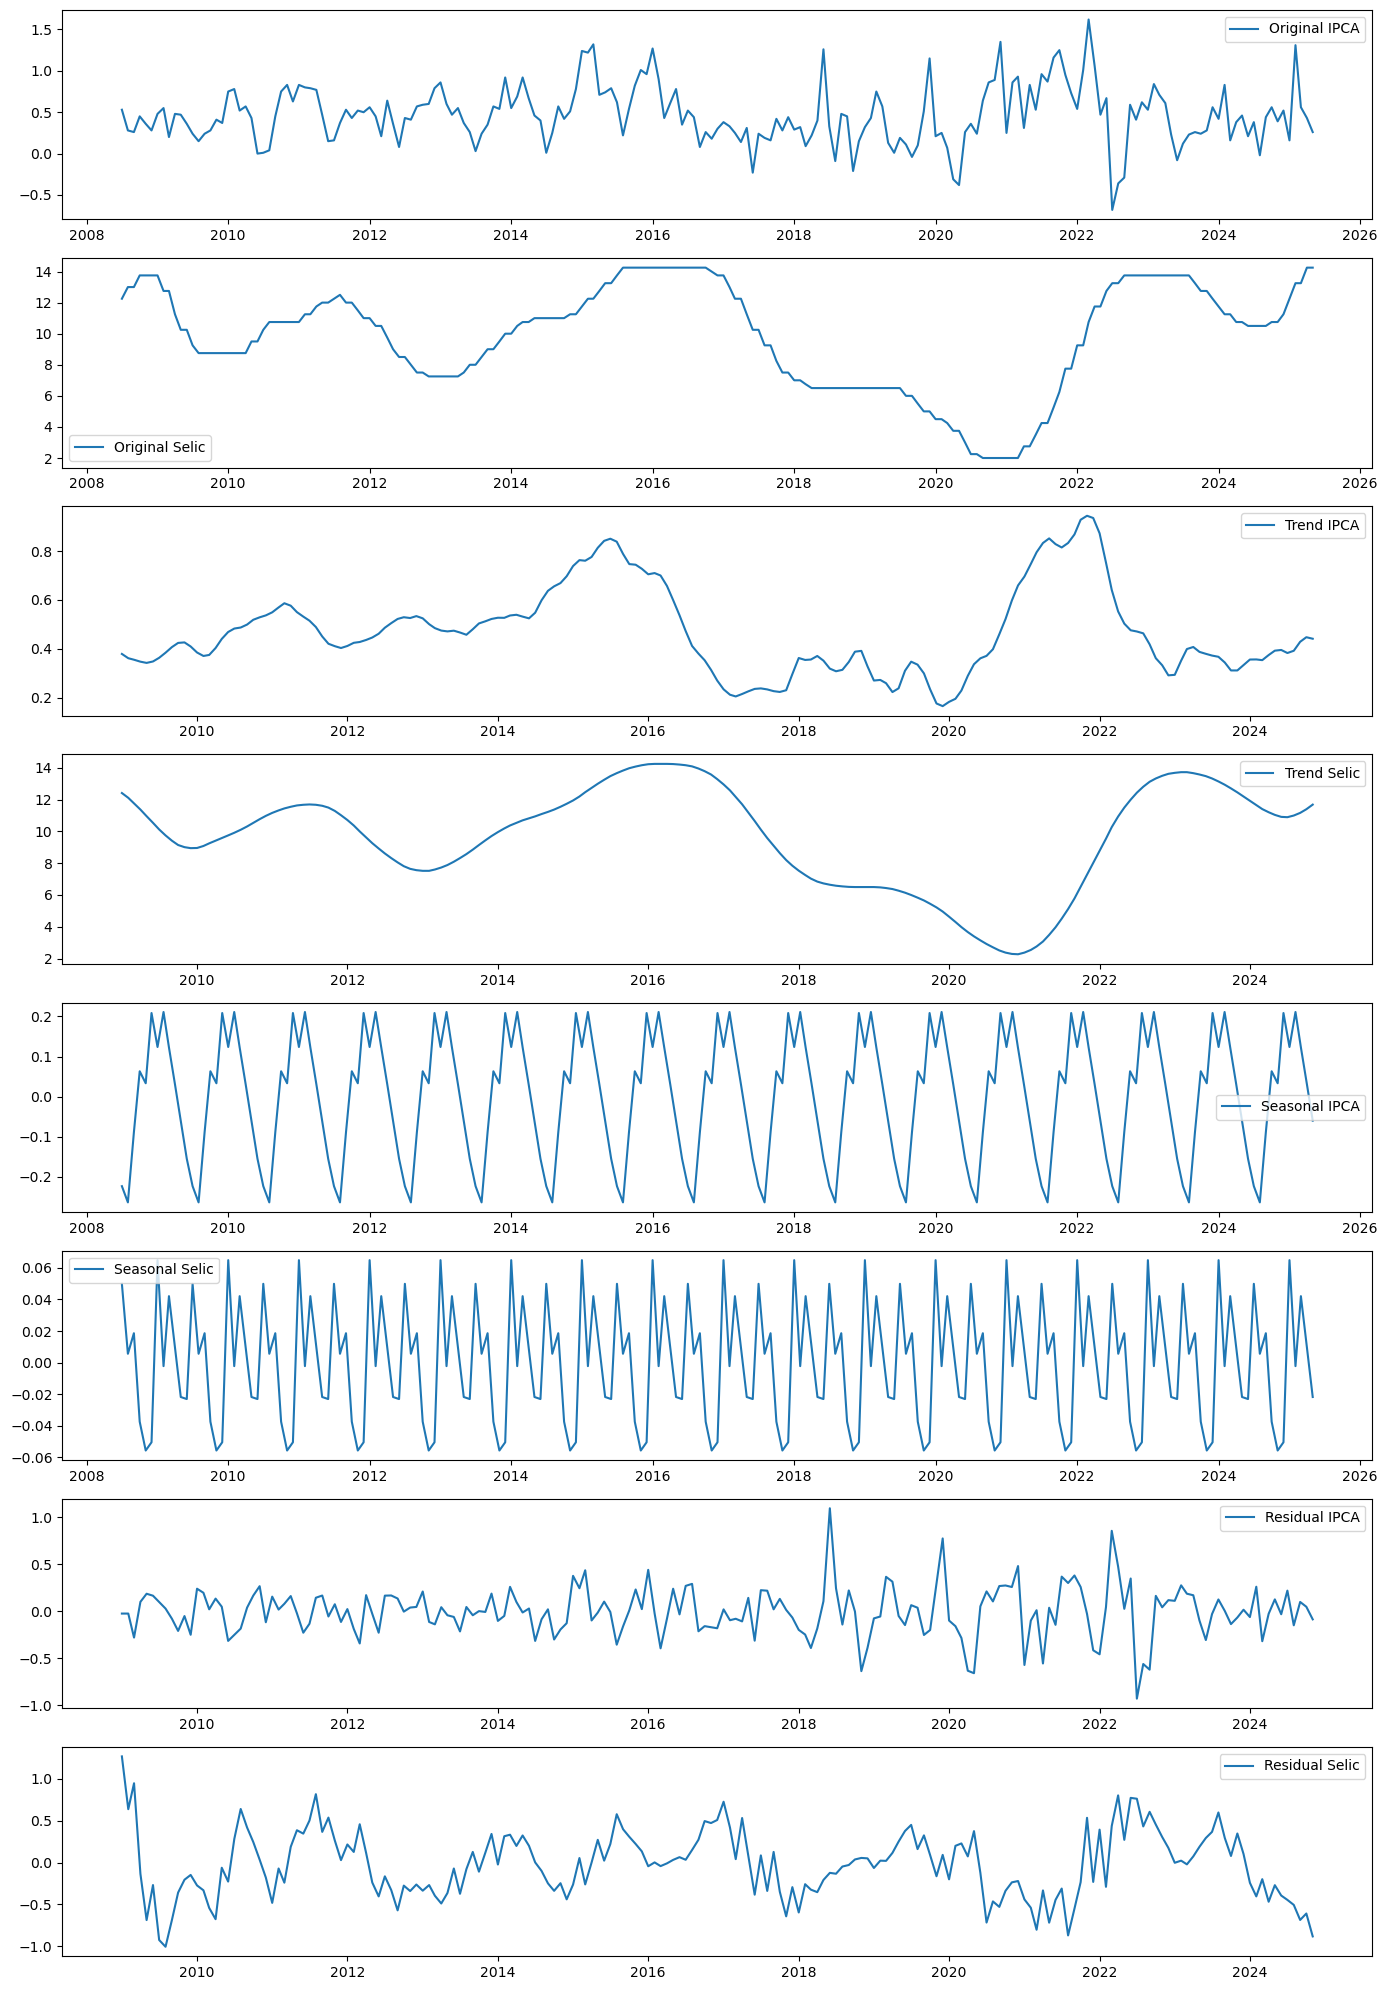

In [338]:
plt.figure(figsize=(14,20))

plt.subplot(811)
plt.plot(merged["IPCA"], label = "Original IPCA")
plt.legend()

plt.subplot(812)
plt.plot(merged["Selic"], label = "Original Selic")
plt.legend()

plt.subplot(813)
plt.plot(trend_ipca, label = "Trend IPCA")
plt.legend()

plt.subplot(814)
plt.plot(trend_selic, label = "Trend Selic")
plt.legend()

plt.subplot(815)
plt.plot(seasonal_ipca, label = "Seasonal IPCA")
plt.legend()

plt.subplot(816)
plt.plot(seasonal_selic, label = "Seasonal Selic")
plt.legend()

plt.subplot(817)
plt.plot(residual_ipca, label = "Residual IPCA")
plt.legend()

plt.subplot(818)
plt.plot(residual_selic, label = "Residual Selic")
plt.legend()

plt.tight_layout()
plt.show()

### Autocorrelação

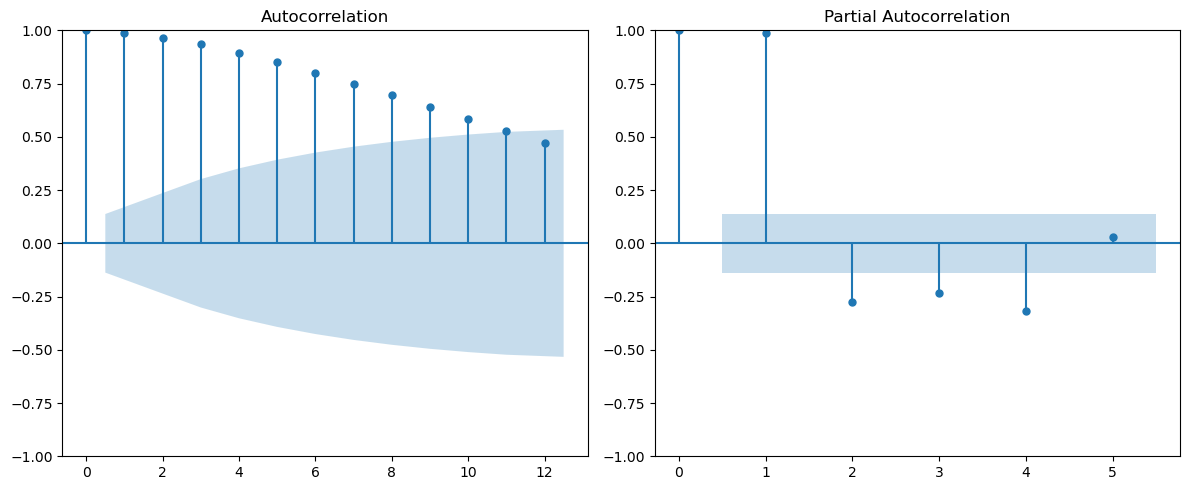

In [339]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

tsaplots.plot_acf(merged["Selic"], lags = 12, ax = axes[0])
fig = tsaplots.plot_pacf(merged["Selic"], lags = 5, method = "ywm", ax = axes[1])

plt.tight_layout()
plt.show()

#### Selic tem autocorrelação estatisticamente significativa dentro de 9 meses, mas isso conta os meses intermediários. Se contar os meses independentes, aparece uma autocorrelação de 1 mês.

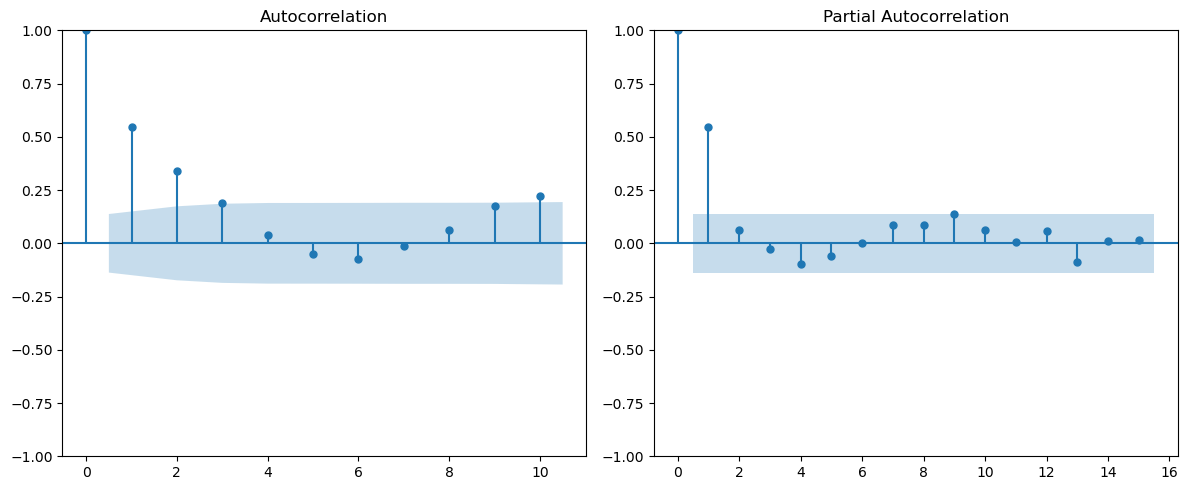

In [340]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

tsaplots.plot_acf(merged["IPCA"], lags = 10, ax = axes[0])
fig = tsaplots.plot_pacf(merged["IPCA"], lags = 15, method = "ywm", ax = axes[1])

plt.tight_layout()
plt.show()

#### IPCA tem autocorrelação estatisticamente significativa dentro de 4 meses, mas dos meses independentes são só 2.

## Regressão com Lag

In [341]:
merged["Selic_Lag1"] = merged["Selic"].shift(1)
merged["Selic_Lag2"] = merged["Selic"].shift(2)
merged["Selic_Lag3"] = merged["Selic"].shift(3)
merged["Selic_Lag4"] = merged["Selic"].shift(4)

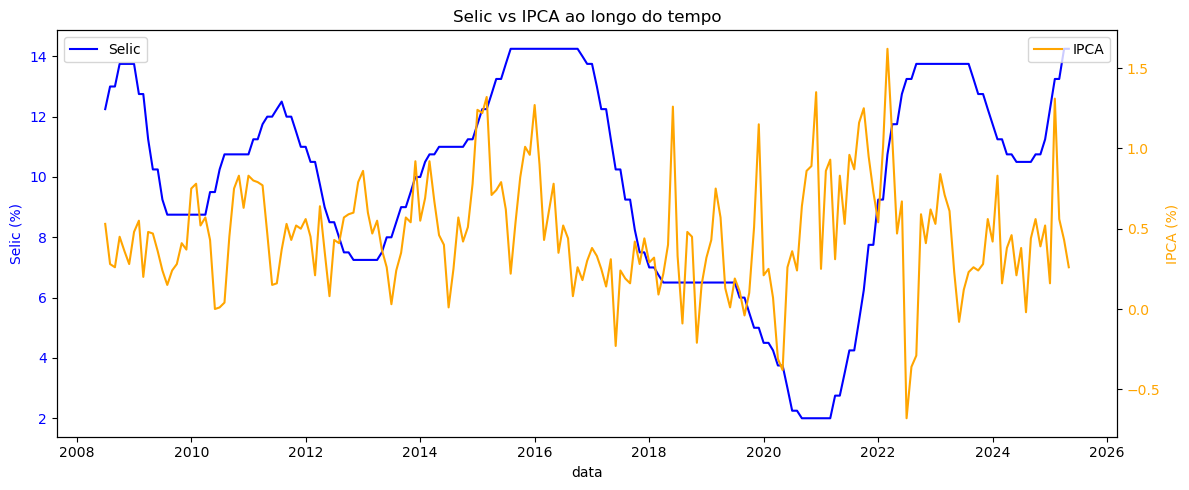

In [342]:
fig, ax1 = plt.subplots(figsize=(12,5))

# Primeiro eixo Y: Selic
sns.lineplot(data=merged, x="data", y="Selic", ax=ax1, color="blue", label="Selic")
ax1.set_ylabel("Selic (%)", color="blue")
ax1.tick_params(axis='y', labelcolor='blue')

# Segundo eixo Y: IPCA
ax2 = ax1.twinx()
sns.lineplot(data=merged, x="data", y="IPCA", ax=ax2, color="orange", label="IPCA")
ax2.set_ylabel("IPCA (%)", color="orange")
ax2.tick_params(axis='y', labelcolor='orange')

plt.xticks(rotation=45)
plt.title("Selic vs IPCA ao longo do tempo")
plt.tight_layout()
plt.show()

In [343]:
modelo = smf.ols('Selic ~ IPCA + Selic_Lag1 + Selic_Lag2 + Selic_Lag3 + Selic_Lag4', data=merged).fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                  Selic   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     4379.
Date:                Wed, 11 Jun 2025   Prob (F-statistic):          1.57e-196
Time:                        21:45:28   Log-Likelihood:                -54.044
No. Observations:                 199   AIC:                             120.1
Df Residuals:                     193   BIC:                             139.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1658      0.080      2.064      0.0

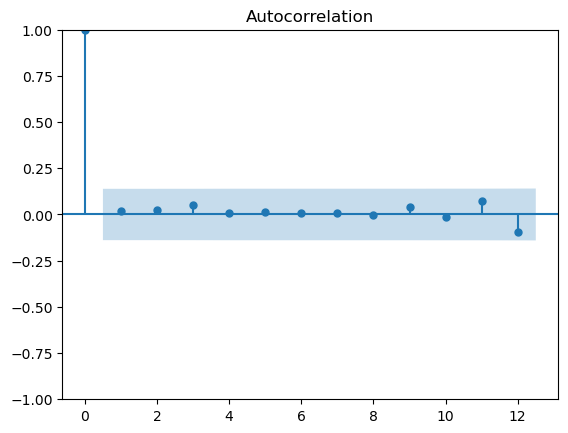

In [344]:
tsaplots.plot_acf(modelo.resid, lags = 12)
plt.show()

In [345]:
acorr_ljungbox(modelo.resid, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,1.183261,0.99963


<Axes: ylabel='Count'>

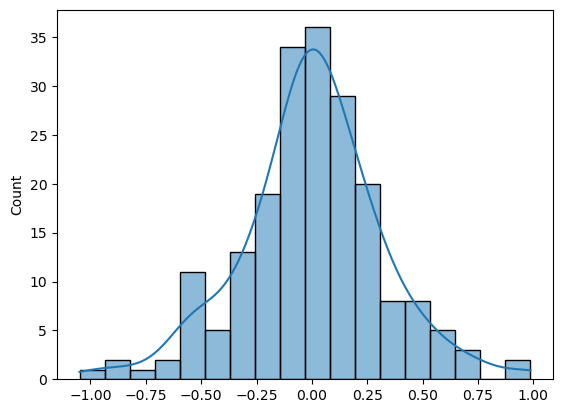

In [346]:
sns.histplot(modelo.resid, kde=True)

## ARIMA

In [ ]:
# MEDIA MOVEL
janela = 12
k = 2

media_movel = merged["Selic"].rolling(window=janela).mean()
desvio = merged["Selic"].rolling(window=janela).std()

banda_superior = media_movel + k * desvio
banda_inferior = media_movel - k * desvio

# Plot
plt.figure(figsize=(10, 5))
plt.plot(merged["Selic"], label="Selic", color="black")
plt.plot(media_movel, label="Média móvel", color="blue")
plt.plot(banda_superior, linestyle='--', color="gray", label="+2σ")
plt.plot(banda_inferior, linestyle='--', color="gray", label="-2σ")
plt.fill_between(merged.index, banda_inferior, banda_superior, color="gray", alpha=0.1)
plt.legend()
plt.title("Selic com média móvel e bandas de desvio padrão")
plt.grid(True)
plt.show()


In [409]:
result = adfuller(merged["Selic"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Serie é estacionária")

ADF Statistic: -3.778884236861361
p-value: 0.003130897964278072
Serie é estacionária


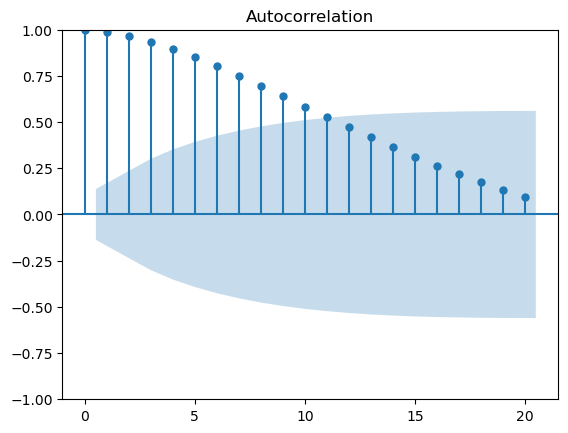

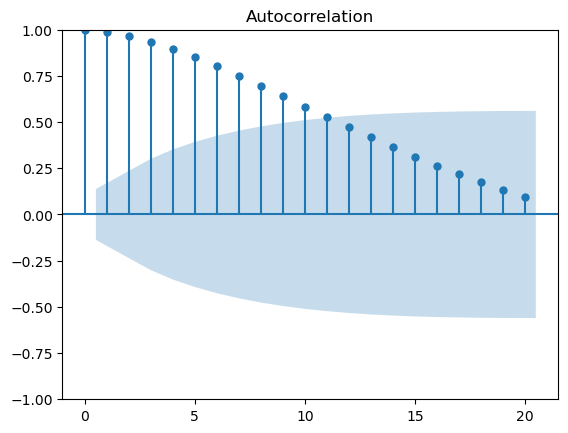

In [410]:
tsaplots.plot_acf(merged["Selic"], lags=20)

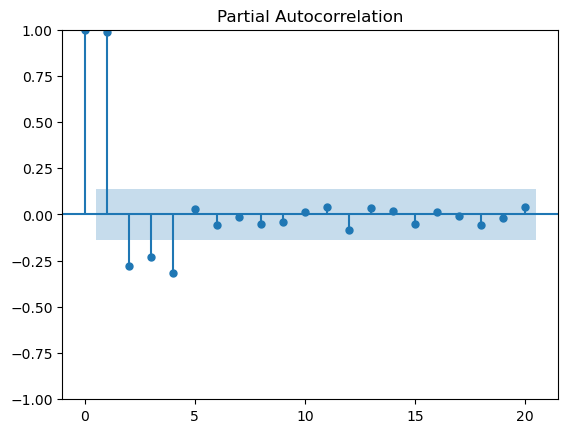

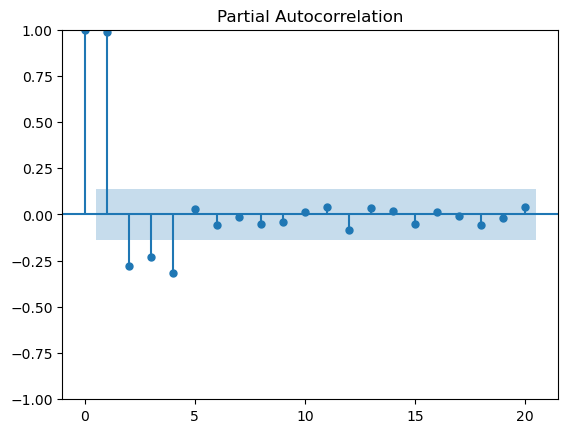

In [411]:
tsaplots.plot_pacf(merged["Selic"], lags=20)

In [418]:
modelo_arima = ARIMA(merged["Selic"], order=(4, 0, 10)).fit()
#p,d,q. p = 1 por causa do grafico PACF. d = 0 porque foram 0 diferenciações. q = 10 por causa do gráfico ACF
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Selic   No. Observations:                  203
Model:                ARIMA(4, 0, 10)   Log Likelihood                 -58.047
Date:                Wed, 11 Jun 2025   AIC                            148.094
Time:                        23:23:24   BIC                            201.106
Sample:                    07-01-2008   HQIC                           169.541
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9678      1.202      8.296      0.000       7.613      12.323
ar.L1          1.2842      0.258      4.968      0.000       0.778       1.791
ar.L2         -0.5000      0.492     -1.015      0.3

C:\Users\leona\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


#### Testando coeficientes mais simples

In [419]:
modelo_arima = ARIMA(merged["Selic"], order=(4, 0, 5)).fit()
print(modelo_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Selic   No. Observations:                  203
Model:                 ARIMA(4, 0, 5)   Log Likelihood                 -60.423
Date:                Wed, 11 Jun 2025   AIC                            142.845
Time:                        23:23:38   BIC                            179.290
Sample:                    07-01-2008   HQIC                           157.589
                         - 05-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0336      1.082      9.275      0.000       7.913      12.154
ar.L1          1.2005      0.753      1.595      0.111      -0.275       2.676
ar.L2          0.2068      0.938      0.221      0.8

C:\Users\leona\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


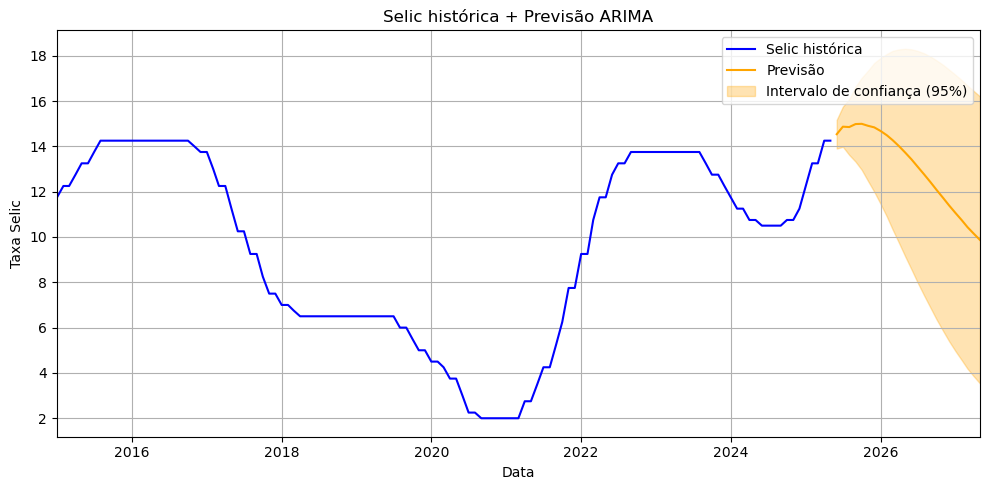

In [427]:
last_date = merged.index[-1]

forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=24, freq='MS')

forecast = modelo_arima.get_forecast(steps=24)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 5))

plt.plot(merged.index, merged["Selic"], label='Selic histórica', color='blue')

plt.plot(forecast_index, forecast.predicted_mean, label='Previsão', color='orange')

plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')
plt.xlim(pd.to_datetime("2015-01-01"), forecast_index[-1])

plt.title("Selic histórica + Previsão ARIMA")
plt.xlabel("Data")
plt.ylabel("Taxa Selic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### O processo de achar os valores ideais de p,q e d e as diferenciações pode ser trabalhoso. Para contornar esse problema, existe a autoarima

In [421]:
#!pip install pmdarima
from pmdarima import auto_arima

modelo_auto = auto_arima(merged["Selic"], seasonal=False, stepwise=True, trace=True)

print(modelo_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=150.884, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1528.972, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1260.930, Time=0.34 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=208.612, Time=0.39 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=189.439, Time=0.79 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=152.881, Time=0.56 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=152.881, Time=0.41 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=248.897, Time=0.16 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=177.702, Time=0.56 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=167.472, Time=0.58 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=149.775, Time=0.97 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=149.641, Time=1.02 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=150.241, Time=0.81 sec


C:\Users\leona\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(5,0,3)(0,0,0)[0]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "C:\Users\leona\anaconda3\Lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "C:\Users\leona\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "C:\Users\leona\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
                           ^^^^^^^^^^^^^^
  File "C:\Users\leona\anaconda3\Lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
             ^^^^^^^^^^
  File "C:\Users\leona\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", line 704, in fit
    mlefit = su

 ARIMA(5,0,3)(0,0,0)[0]             : AIC=inf, Time=nan sec
 ARIMA(4,0,4)(0,0,0)[0]             : AIC=151.910, Time=1.63 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=150.588, Time=1.43 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=145.267, Time=1.31 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=142.291, Time=1.22 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=149.400, Time=0.37 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=148.526, Time=0.52 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=149.478, Time=0.49 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=137.659, Time=1.86 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=137.171, Time=1.29 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=154.984, Time=0.96 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=135.877, Time=0.56 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=178.271, Time=0.55 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=137.038, Time=0.94 sec

Best model:  ARIMA(4,0,0)(0,0,0)[0] intercept
Total fit time: 22.013 seconds
                 

#### Como a ARIMA encontrada é ARIMA(4,0,0), podemos concluir que isso é simplesmente uma AutoRegression.

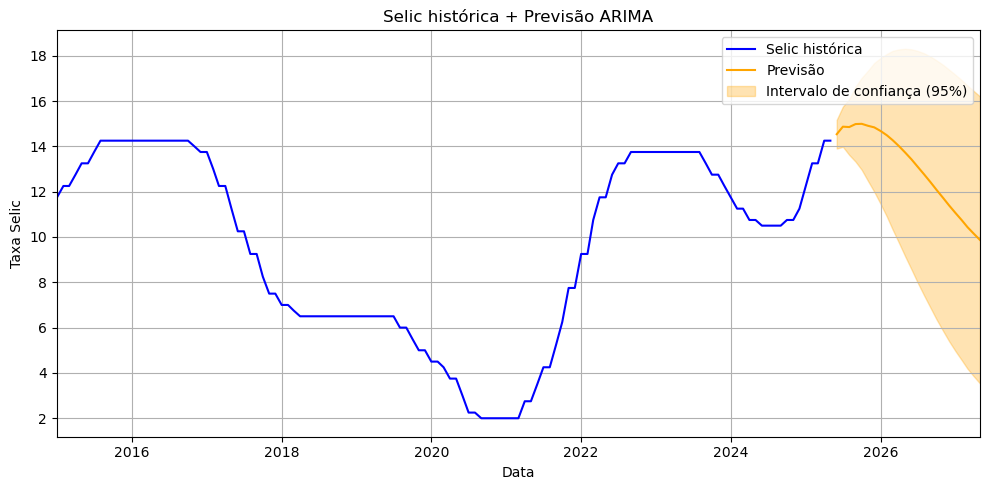

In [426]:
modelo_arima = ARIMA(merged["Selic"], order=(4, 0, 0)).fit()

last_date = merged.index[-1]

forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=24, freq='MS')

forecast = modelo_arima.get_forecast(steps=24)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 5))

plt.plot(merged.index, merged["Selic"], label='Selic histórica', color='blue')

plt.plot(forecast_index, forecast.predicted_mean, label='Previsão', color='orange')

plt.fill_between(forecast_index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')

plt.xlim(pd.to_datetime("2015-01-01"), forecast_index[-1])

plt.title("Selic histórica + Previsão ARIMA")
plt.xlabel("Data")
plt.ylabel("Taxa Selic")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Vector Autoregression (VAR)

In [433]:
result = adfuller(merged["Selic"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Serie SELIC é estacionária \n")

result = adfuller(merged["IPCA"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
print("Serie IPCA é estacionária \n")

ADF Statistic: -3.778884236861361
p-value: 0.003130897964278072
Serie SELIC é estacionária 

ADF Statistic: -7.655175601004995
p-value: 1.7467315479256404e-11
Serie IPCA é estacionária 



In [434]:
data_var = merged[['Selic', 'IPCA']].dropna()
model = VAR(data_var)

lag_order_results = model.select_order(maxlags=24)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       0.5137      0.5493       1.671      0.5281
1       -4.113      -4.006     0.01637      -4.069
2       -4.255      -4.077     0.01419      -4.183
3       -4.465      -4.215     0.01151      -4.364
4      -4.684*     -4.363*   0.009243*     -4.554*
5       -4.650      -4.258    0.009562      -4.491
6       -4.611      -4.148    0.009949      -4.423
7       -4.574      -4.040     0.01032      -4.358
8       -4.546      -3.941     0.01062      -4.301
9       -4.568      -3.891     0.01040      -4.293
10      -4.559      -3.811     0.01050      -4.255
11      -4.546      -3.727     0.01064      -4.214
12      -4.533      -3.643     0.01079      -4.172
13      -4.503      -3.542     0.01112      -4.113
14      -4.480      -3.447     0.01140      -4.061
15      -4.441      -3.337     0.01187      -3.993
16      -4.428      -3.253     

In [437]:
lag_order = lag_order_results.bic
model_fitted = model.fit(lag_order)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 11, Jun, 2025
Time:                     23:38:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -4.36486
Nobs:                     199.000    HQIC:                  -4.54219
Log likelihood:          -82.7940    FPE:                 0.00944164
AIC:                     -4.66275    Det(Omega_mle):      0.00864225
--------------------------------------------------------------------
Results for equation Selic
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const            0.091431         0.084567            1.081           0.280
L1.Selic         0.930129         0.064505           14.419           0.000
L1.IPCA          0.097180         0.078530            1.237           0.216
L2.S

### Interpretação:
- Os coeficientes para termos SELIC da equação SELIC indicam que essa curva é fortemente autocorrelacionadas e não depende tanto assim do IPCA. O mesmo serve para o IPCA

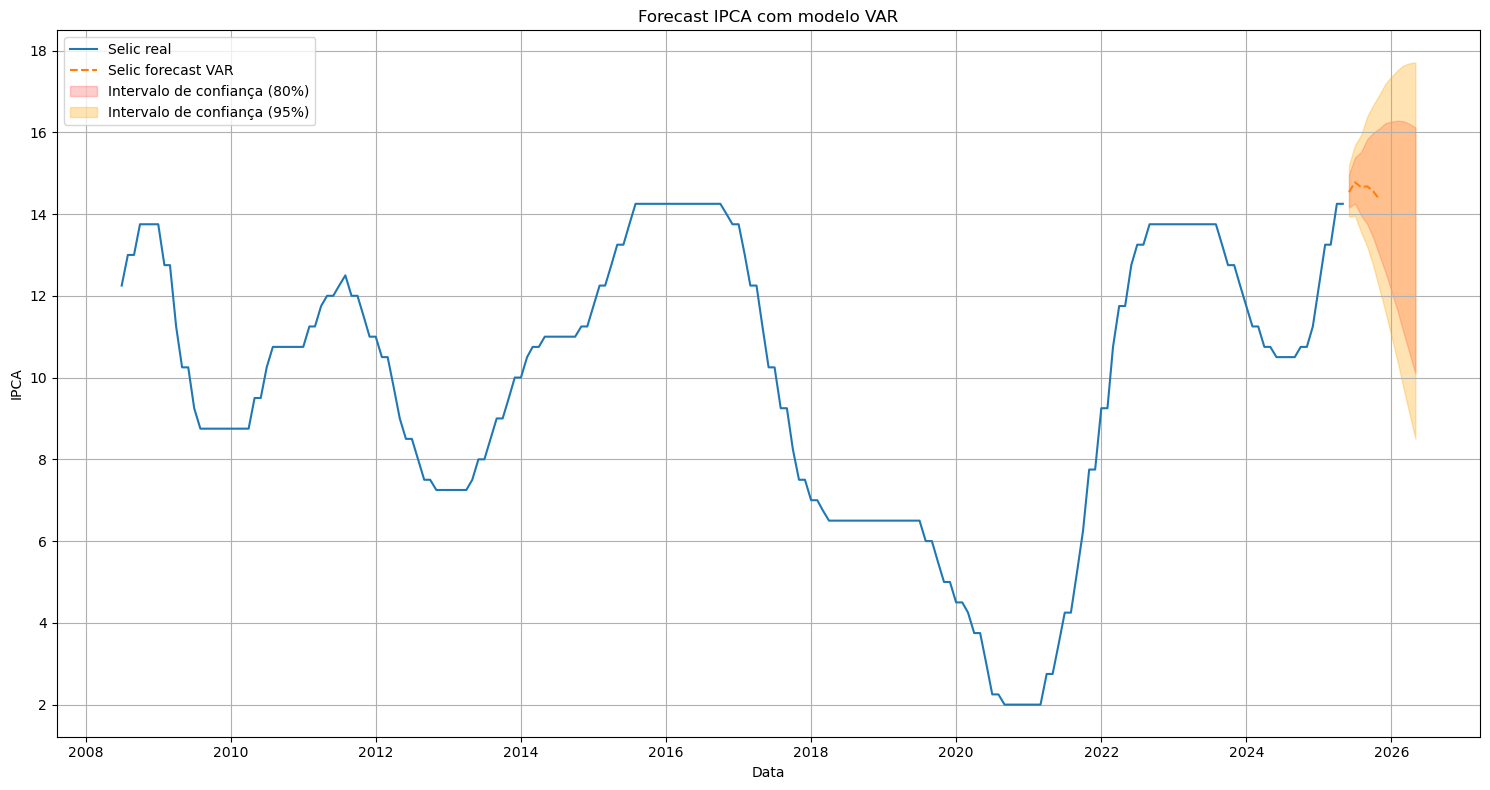

In [438]:
forecast_input = data_var.values[-lag_order:]
forecast_95, lower_95, upper_95 = model_fitted.forecast_interval(y=forecast_input, steps=12, alpha=0.05)
forecast_80, lower_80, upper_80 = model_fitted.forecast_interval(y=forecast_input, steps=12, alpha=0.20)

forecast_index = pd.date_range(start=data_var.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')

forecast_df_95 = pd.DataFrame(forecast_95, index=forecast_index, columns=data_var.columns)
lower_df_95 = pd.DataFrame(lower_95, index=forecast_index, columns=data_var.columns)
upper_df_95 = pd.DataFrame(upper_95, index=forecast_index, columns=data_var.columns)

forecast_df_80 = pd.DataFrame(forecast_80, index=forecast_index, columns=data_var.columns)
lower_df_80 = pd.DataFrame(lower_80, index=forecast_index, columns=data_var.columns)
upper_df_80 = pd.DataFrame(upper_80, index=forecast_index, columns=data_var.columns)


plt.figure(figsize=(15, 8))
plt.plot(data_var['Selic'], label='Selic real')
plt.plot(forecast_df['Selic'], label='Selic forecast VAR', linestyle='--')
plt.fill_between(forecast_index,
                 lower_df_80['Selic'],
                 upper_df_80['Selic'],
                 color='red', alpha=0.2, label='Intervalo de confiança (80%)')
plt.fill_between(forecast_index,
                 lower_df_95['Selic'],
                 upper_df_95['Selic'],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')
plt.legend(loc='upper left')
plt.title("Forecast IPCA com modelo VAR")
plt.xlabel("Data")
plt.ylabel("IPCA")
plt.grid(True)
plt.tight_layout()
plt.show()

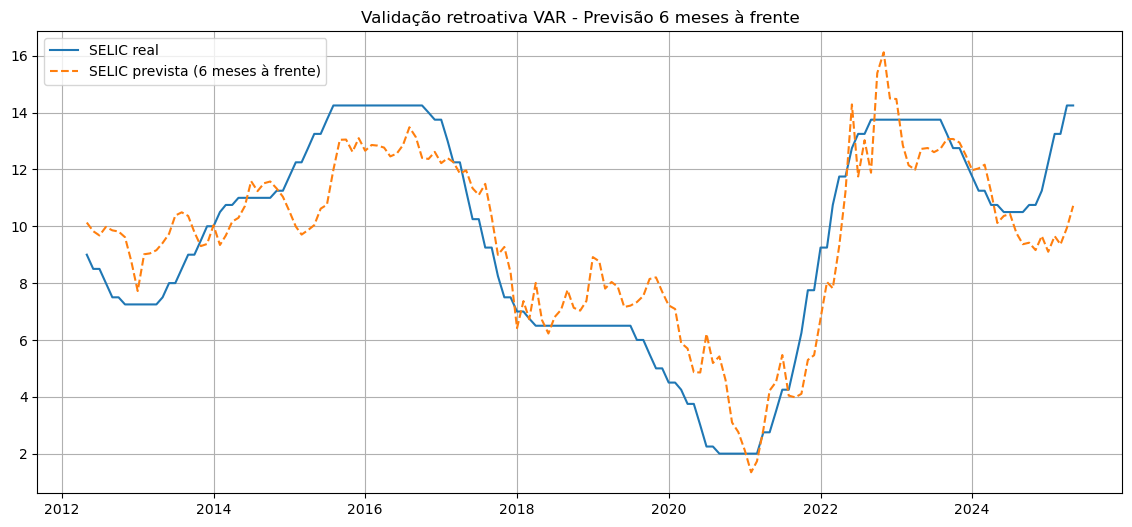

In [439]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

h = 6 
start_point = 40
predictions = []
true_values = []

for t in range(start_point, len(data_var) - h):
    train = data_var.iloc[:t]
    model = VAR(train)
    model_fitted = model.fit(maxlags=4)
    
    forecast_input = train.values[-model_fitted.k_ar:]
    forecast = model_fitted.forecast(forecast_input, steps=h)
    
    predictions.append(forecast[-1])
    true_values.append(data_var.iloc[t + h].values)

pred_df = pd.DataFrame(predictions, columns=data_var.columns, index=data_var.index[start_point + h:len(data_var)])
true_df = pd.DataFrame(true_values, columns=data_var.columns, index=pred_df.index)

plt.figure(figsize=(14,6))
plt.plot(true_df['Selic'], label='SELIC real')
plt.plot(pred_df['Selic'], label=f'SELIC prevista ({h} meses à frente)', linestyle='--')
plt.title(f'Validação retroativa VAR - Previsão {h} meses à frente')
plt.legend()
plt.grid(True)
plt.show()


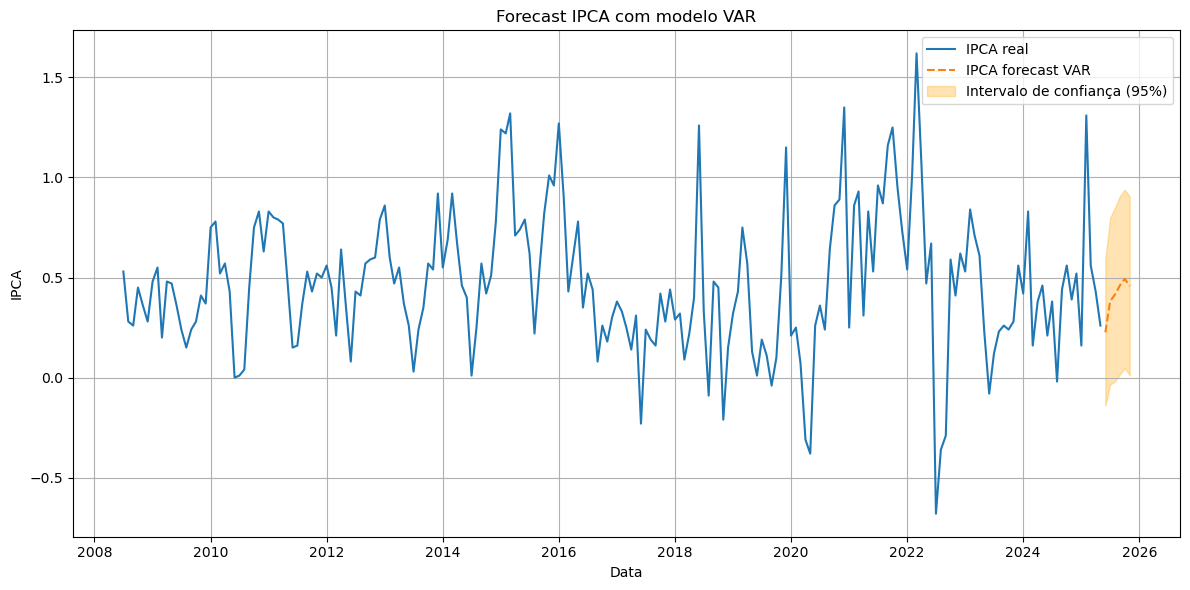

In [440]:
forecast_input = data_var.values[-lag_order:]
forecast, lower, upper = model_fitted.forecast_interval(y=forecast_input, steps=6, alpha=0.2)

forecast_index = pd.date_range(start=data_var.index[-1] + pd.offsets.MonthBegin(), periods=6, freq='MS')

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=data_var.columns)
lower_df = pd.DataFrame(lower, index=forecast_index, columns=data_var.columns)
upper_df = pd.DataFrame(upper, index=forecast_index, columns=data_var.columns)

plt.figure(figsize=(12, 6))
plt.plot(data_var['IPCA'], label='IPCA real')
plt.plot(forecast_df['IPCA'], label='IPCA forecast VAR', linestyle='--')
plt.fill_between(forecast_index,
                 lower_df['IPCA'],
                 upper_df['IPCA'],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')
plt.legend()
plt.title("Forecast IPCA com modelo VAR")
plt.xlabel("Data")
plt.ylabel("IPCA")
plt.grid(True)
plt.tight_layout()
plt.show()


### O modelo está muito simples, pois há vários outros fatores que impactam a inflação e a SELIC e não estão descritas. Abaixo, adicionarei a taxa de câmbio entre dolar e real

In [560]:
dolar = pd.read_csv("./dolar.csv", sep=';')
selic = pd.read_csv("./selic.csv").reset_index(drop=True)
ipca = pd.read_csv("./ipca.csv", sep=";")

In [561]:
selic["Data"] = pd.to_datetime(selic["Data"], format='%d/%m/%Y')

selic = selic.set_index("Data")

selic_mensal = selic.resample("M").mean()

In [562]:
dolar["Data"] = pd.to_datetime(dolar["Data"], format="%d/%m/%Y")
dolar["dolar"] = dolar["dolar"].astype(str).str.replace(",",".")
dolar["dolar"] = dolar["dolar"].astype(float)
dolar = dolar.set_index("Data")
dolar = dolar.resample("M").mean()
dolar.index = pd.to_datetime(dolar.index).to_period('M').to_timestamp()

In [563]:
ipca = ipca[:-1]
ipca["Data"] = pd.to_datetime(ipca["Data"], format="%m/%Y")
ipca = ipca.set_index("Data")
ipca["ipca"] = ipca["ipca"].astype(str).str.replace(",",".")
ipca["ipca"] = ipca["ipca"].astype(float)

In [564]:
ipca = ipca.reset_index()
merged = pd.merge(selic, ipca, on = "Data", how="inner")
merged = pd.merge(merged, dolar, on = "Data", how="inner")
merged = merged.rename(columns={"ipca":"IPCA"})
merged = merged.rename(columns={"Data":"data"})
merged = merged.rename(columns={"Unnamed: 1":"Selic"})
merged = merged.set_index("data")
merged.index = pd.DatetimeIndex(merged.index).to_period('M').to_timestamp()

<Axes: xlabel='data', ylabel='dolar'>

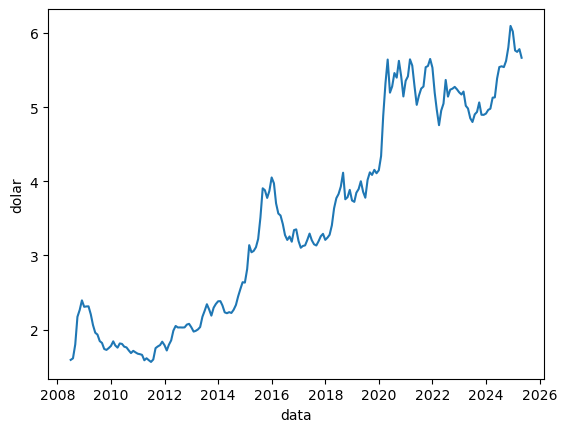

In [566]:
sns.lineplot(data=merged,y=merged["dolar"], x=merged.index)

In [567]:
# Teste de Dickey-Fuller
result = adfuller(merged["dolar"])

In [568]:
print("p-value: ", result[1])
print("Não é estacionário")

p-value:  0.8848385559894649
Não é estacionário


In [569]:
dolar_diff = merged["dolar"].diff().dropna()

In [570]:
result = adfuller(dolar_diff)

In [571]:
print("p-value: ", result[1])
print("É estacionário")

p-value:  4.0278489568813103e-16
É estacionário


In [572]:
merged["dolar_diff"] = dolar_diff
data_var = merged[['Selic', 'IPCA',"dolar_diff"]].dropna()
model = VAR(data_var)

lag_order_results = model.select_order(maxlags=24)
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -3.447      -3.393     0.03184      -3.425
1       -8.113     -7.899*   0.0002996      -8.026
2       -8.215      -7.840   0.0002705      -8.063
3       -8.366      -7.830   0.0002327      -8.148
4      -8.594*      -7.897  0.0001853*     -8.312*
5       -8.525      -7.667   0.0001988      -8.177
6       -8.453      -7.434   0.0002139      -8.039
7       -8.471      -7.291   0.0002103      -7.993
8       -8.413      -7.073   0.0002231      -7.870
9       -8.405      -6.903   0.0002255      -7.796
10      -8.387      -6.724   0.0002303      -7.713
11      -8.353      -6.530   0.0002390      -7.614
12      -8.317      -6.333   0.0002488      -7.513
13      -8.323      -6.178   0.0002486      -7.453
14      -8.250      -5.944   0.0002691      -7.315
15      -8.192      -5.725   0.0002871      -7.191
16      -8.165      -5.538   0.

In [584]:
lag_order = 4
model_fitted = model.fit(lag_order)
print(model_fitted.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 12, Jun, 2025
Time:                     00:33:46
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -8.10876
Nobs:                     185.000    HQIC:                  -8.51251
Log likelihood:           64.3464    FPE:                0.000152713
AIC:                     -8.78765    Det(Omega_mle):     0.000124565
--------------------------------------------------------------------
Results for equation Selic
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.099424         0.084159            1.181           0.237
L1.Selic              0.907055         0.065538           13.840           0.000
L1.IPCA               0.166316         0.079833            2

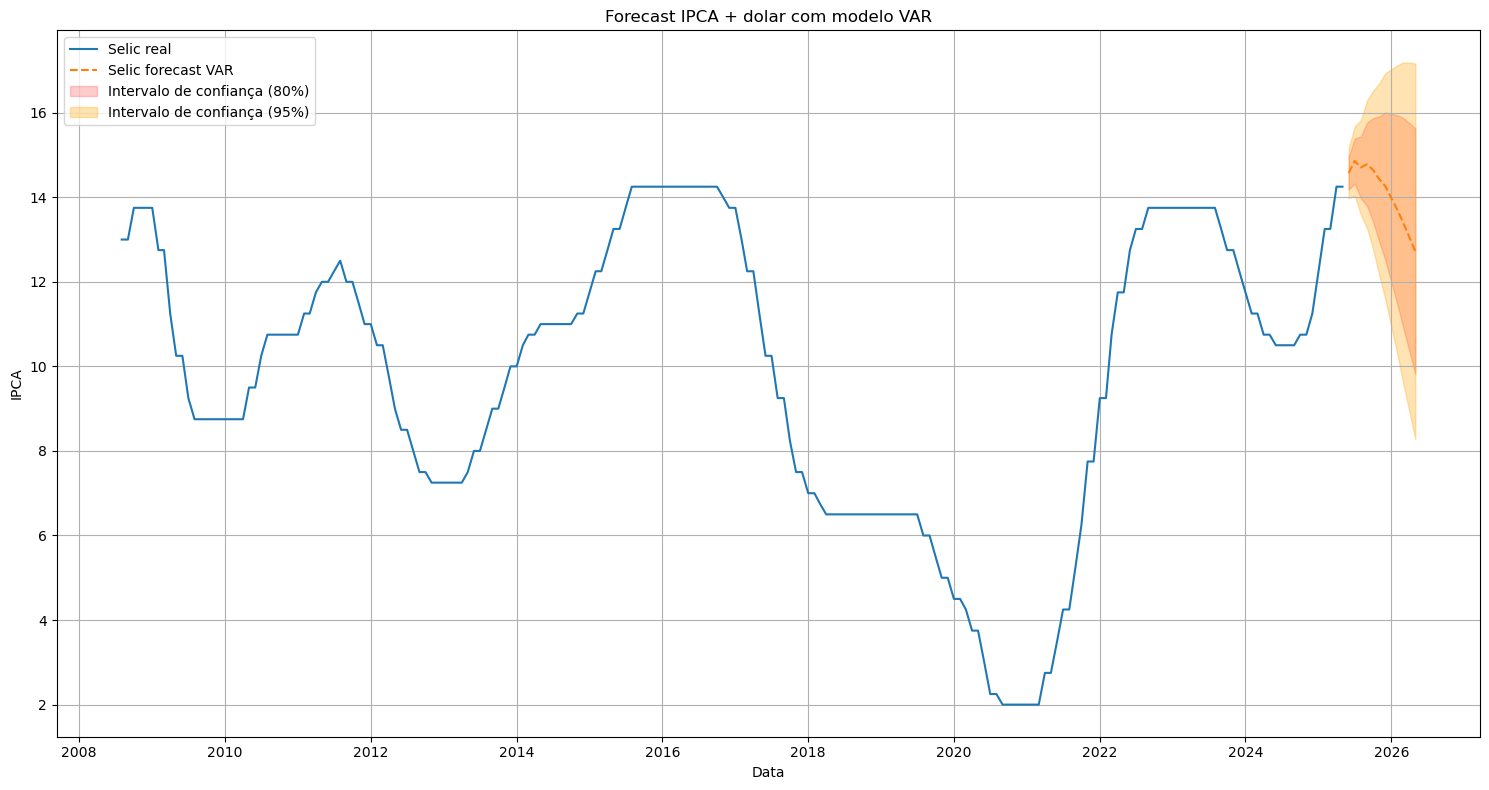

In [590]:
forecast_input = data_var.values[-lag_order:]
forecast_95, lower_95, upper_95 = model_fitted.forecast_interval(y=forecast_input, steps=12, alpha=0.05)
forecast_80, lower_80, upper_80 = model_fitted.forecast_interval(y=forecast_input, steps=12, alpha=0.20)

forecast_index = pd.date_range(start=data_var.index[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')

forecast_df_95 = pd.DataFrame(forecast_95, index=forecast_index, columns=data_var.columns)
lower_df_95 = pd.DataFrame(lower_95, index=forecast_index, columns=data_var.columns)
upper_df_95 = pd.DataFrame(upper_95, index=forecast_index, columns=data_var.columns)

forecast_df_80 = pd.DataFrame(forecast_80, index=forecast_index, columns=data_var.columns)
lower_df_80 = pd.DataFrame(lower_80, index=forecast_index, columns=data_var.columns)
upper_df_80 = pd.DataFrame(upper_80, index=forecast_index, columns=data_var.columns)


plt.figure(figsize=(15, 8))
plt.plot(data_var['Selic'], label='Selic real')
plt.plot(forecast_df_95['Selic'], label='Selic forecast VAR', linestyle='--')
plt.fill_between(forecast_index,
                 lower_df_80['Selic'],
                 upper_df_80['Selic'],
                 color='red', alpha=0.2, label='Intervalo de confiança (80%)')
plt.fill_between(forecast_index,
                 lower_df_95['Selic'],
                 upper_df_95['Selic'],
                 color='orange', alpha=0.3, label='Intervalo de confiança (95%)')
plt.legend(loc='upper left')
plt.title("Forecast IPCA + dolar com modelo VAR")
plt.xlabel("Data")
plt.ylabel("IPCA")
plt.grid(True)
plt.tight_layout()
plt.show()

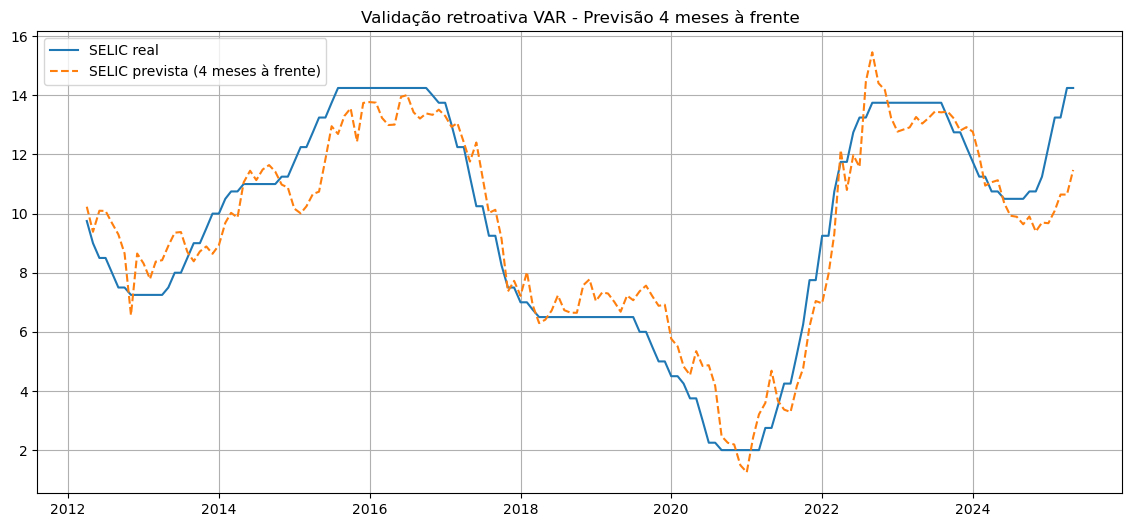

In [591]:
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

h = 4
start_point = 40
predictions = []
true_values = []

for t in range(start_point, len(data_var) - h):
    train = data_var.iloc[:t]
    model = VAR(train)
    model_fitted = model.fit(maxlags=4)
    
    forecast_input = train.values[-model_fitted.k_ar:]
    forecast = model_fitted.forecast(forecast_input, steps=h)
    
    predictions.append(forecast[-1])
    true_values.append(data_var.iloc[t + h].values)

pred_df = pd.DataFrame(predictions, columns=data_var.columns, index=data_var.index[start_point + h:len(data_var)])
true_df = pd.DataFrame(true_values, columns=data_var.columns, index=pred_df.index)

plt.figure(figsize=(14,6))
plt.plot(true_df['Selic'], label='SELIC real')
plt.plot(pred_df['Selic'], label=f'SELIC prevista ({h} meses à frente)', linestyle='--')
plt.title(f'Validação retroativa VAR - Previsão {h} meses à frente')
plt.legend()
plt.grid(True)
plt.show()

In [596]:
#Granger Causality
causality = model_fitted.test_causality('Selic', ['IPCA'], kind='f')
print(causality.summary())

Granger causality F-test. H_0: IPCA does not Granger-cause Selic. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.404          2.388   0.009 (4, 540)
----------------------------------------------
